In [2]:
import math
import ciw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import random as rand
from IPython.display import clear_output

/var/folders/y7/c980x4qd7flfptjj2fjrnn0r0000gn/T/ipykernel_47595/883676184.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [33]:
class queue:
    '''
    A queue system class. 
    '''
    def __init__(self, lbda: float, mu: float, c: float, mode = str, tandem_queue: bool = False,
                cv_a: float = None,  cv_s: float = None, unit: str = 'years'): 
        '''
        Initialize necessary parameter for a new queue system class.
        \n==INPUT==
        `lbda`: `float`
            𝜆: Arrival Rate
        `mu`: `float`
            µ: Service Rate
        `c`: `float`
            Number of servers
        `mode`: `str`
            Queue system configuration
        `tandem_queue`: `bool`, default `False`
            Whether the servers are sequentially aligned where a user must finish one queue before joining another. 
        `cv_a`, `cv_s`: `float`, default `None`
            Exclusive for `mode = 'G/G'. Coefficient of variation for arrival rate and service rate.
        `unit`: `str`, default `years`
            Unit for annotation usage only. 
        '''
        # Input check and conditional properties
        self.mode = mode
        if self.mode not in ['M/M', 'G/G']:
            raise ValueError(f'{mode} queue system not currently supported. Queue system can be either "M/M" or "G/G". ')
        elif self.mode == 'G/G':
            if cv_s is None or cv_a is None: 
                raise ValueError ('Coefficient of Variations cv_s and cv_s must not be none when mode is G/G')
            else: 
                self.cvs = cv_s
                self.cva = cv_a
        # Universal properties
        self.lbda = lbda
        self.mu = mu
        self.c = c
        self.tandem = tandem_queue
        self.verbose = 0
        self.unit = unit

    def factorial(self, x):
        if (x == 1) or (x==0):
            return 1
        else:
            # recursive call to the function
            return (x * self.factorial(x-1)) 

    def user_defined_sum(self, c,rho):
        sum = 0
        for n in range(c):
            sum += (c*rho)**n/self.factorial(n) 

        return 1/(sum + (c*rho)**c/(self.factorial(c)*(1-rho)))

    def get_params(self):
        '''
        Get the estimated steady state params of the new queue system using steady state analytical formulas. 
        '''
        if self.mode == 'M/M': 
            self.rho = self.lbda/(self.c * self.mu)                       # Utilization rate
            self.p0 = self.user_defined_sum(self.c, self.rho)             # Empty queue probability
            self.lq = (self.c * self.rho) ** self.c * self.p0 * self.rho\
                    / (self.factorial(self.c) * (1-self.rho)**2)          # Length of queue
            self.l = self.lq + self.lbda/self.mu                          # Length of system
            self.wq = self.lq / self.lbda                                 # time in queue
            self.w = self.l / self.lbda                                   # time in system
        elif self.mode == 'G/G': 
            # Only in G-G Model: 
            self.s = 1 / self.mu # Average service time
            self.a = 1 / self.lbda # Inter-arrival time
            self.cvai = 1 / self.cva # CV of inter-arrival time
            self.cvsi = 1 / self.cvs # CV of service time
            # Other features: 
            self.rho = self.s / (self.c * self.a)          # Utilization rate
            self.wq = self.s / self.c * (self.cvai**2 + self.cvsi**2)/2 * self.rho ** (-1+math.sqrt(2*(self.c+1)))/(1-self.rho) # Time in queue
            self.w = self.wq + self.s # time in system
            self.lq = self.wq * self.lbda # length of queue
            self.l = self.w * self.lbda # length of system
        if self.tandem == True: 
            self.wq = self.wq * 2
            self.w = self.w * 2

        if self.verbose ==1: 
            print(f'Queue system configuration: {self.mode}, arrival rate: {self.lbda:.2f}, service rate: {self.mu:.2f}, total {self.c} server(s).')
            print(f'Is current queue tandem: {self.tandem}')
            print(f'Utilization rate: {self.rho:.3f}')
            print(f'Length of queue: {self.lq:.3f}, length of system: {self.l:.3f}')
            print(f'Time in queue: {self.wq:.3f} {self.unit}, time in system: {self.w:.3f} {self.unit}')
            print('------------------------------------------------------------------------------------------------------------')
    
    def discrete_sim_exp(self, seed:int = 0): 
        '''
        Create a discrete event simulation (`self.sim`) using the given network with exponential simulation on both arrival and service distributions.
        \r Note that this will overwrite any previously-establish `self.sim` instances. 
        \n==INPUT==
        `seed`: `int`, default `0`
            Random state seed to be passed to `ciw.seed()`
        '''
        # Define simulation network: 
        N = ciw.create_network(
            arrival_distributions=[ciw.dists.Exponential(rate=self.lbda)],
            service_distributions=[ciw.dists.Exponential(rate=self.mu)],
            number_of_servers=[self.c])
        ciw.seed(seed)
        # Set up simulation:
        Q = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
        self.sim = Q
        self.sim_type = 'exponential'
    
    def discrete_sim_gamma(self, seed:int = 0): 
        '''
        Create a discrete event simulation (`self.sim`) using the given network with gamma simulation on both arrival and service distributions. 
        \r Note that this will overwrite any previously-establish `self.sim` instances. 
            \r **Only works for G/G/c queue instance!**
        \n==INPUT==
        `seed`: `int`, default `0`
            Random state seed to be passed to `ciw.seed()`
        '''
        # Check for queue instance mode: 
        if self.mode != 'G/G':
            raise ValueError('gamma discrete simulation cannot be initiated under the current instance. Queue system must be created with G/G mode.')
        # Calculate gamma distribution parameters:
        #### Arrival: 
        self.alpha_arrival = (1/self.cva)**2
        self.beta_arrival = self.alpha_arrival / self.lbda
        #### Service:
        self.alpha_service = (1/self.cvs)**2
        self.beta_service = self.alpha_service / self.mu
        # Define simulation network: 
        N = ciw.create_network(
            arrival_distributions=[ciw.dists.Gamma(shape = self.alpha_arrival, scale = self.beta_arrival)],
            service_distributions=[ciw.dists.Gamma(shape = self.alpha_service, scale = self.beta_service)],
            number_of_servers=[self.c])
        ciw.seed(seed)
        # Set up simulation:
        Q = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
        self.sim = Q
        self.sim_type = 'gamma'
    
    def get_sim_record(self, stop_criteria: str = 'customer', stop_count: int = 100000): 
        '''
        Run `self.sim` for one time and generate event records `self.sim_record`.
        \n==INPUT==
        `stop_criteria`: `str`, default `customer`
            Simulation stop criteria. Can be:
            \t > `customer` (stopped when `stop_count` number of customers has reached the exit node)
            \r \t > `time` (stop when simulation time has reached `stop_count`)
        `stop_count`: `int`, default `100000`
            Quantity threshold of stop criteria.
        '''
        # Run simulation:
        if stop_criteria == 'customer':
            self.sim.simulate_until_max_customers(stop_count, progress_bar=True)
        elif stop_criteria == 'time': 
            self.sim.simulate_until_max_time(stop_count, progress_bar=True)
        else: 
            raise ValueError('Stop criteria must be either "customer" or "time". ')
        # Fetch simulation records
        recs = self.sim.get_all_records()
        df = pd.DataFrame(recs)
        df.sort_values(by='arrival_date',inplace=True)
        df['inter_arrival'] = df.arrival_date - df.arrival_date.shift(1,fill_value=0)
        df['system_time'] = df.exit_date - df.arrival_date
        df = df[['id_number',
                 'server_id',
                 'arrival_date',
                 'waiting_time',
                 'system_time',
                 'service_start_date',
                 'server_id',
                 'service_time',
                 'service_end_date',
                 'exit_date',
                 'queue_size_at_arrival',
                 'queue_size_at_departure']]
        # Upload to class instance: 
        self.sim_record = df
    
    def get_sim_params(self, df:pd.DataFrame = None): 
        '''
        Print out calculate necessary simulation params.
        \nGenerate the following quantities: 
        \n > `self.sim_wq` Average time in queue; 
        \n > `self.sim_w` Average time; 
        \n > `self.sim_util_rate` Average utilization rate of all servers.
        '''
        if df is None: 
            df = self.sim_record
            self.sim_wq = round(df['waiting_time'].mean(),3)
            self.sim_w = round(df['system_time'].mean(),3)
            self.sim_util_rate = [srv.utilisation for srv in self.sim.nodes[1].servers]
        else: 
            # Only used for map_wait_time
            sim_wq = round(df['waiting_time'].mean(),3)
            return sim_wq
        if self.verbose == 1: 
            print(f'{self.sim_type} Simulation result: ')
            print(f'Time in queue: {self.sim_wq:.3f} {self.unit}, time in system: {self.sim_w:.3f} {self.unit}')
            print(f'Server utilization rate: {[round(rate,3) for rate in self.sim_util_rate]}')
            print('------------------------------------------------------------------------------------------------------------')
    
    def get_steady_state(self, start_sim_time: int, sim_time_increments:int, steps: int, 
                          plot:bool = True, show_plot:bool = True):
        '''
        Used to find the minimal simulation time to reach steady state in terms of average wait time.
        \n==INPUT==
        `start_sim_time`: `int`
            Simulation time to start the iteration from
        `sim_time_increments`: `int`
            Increment in simulation time per iteration
        `steps`: `int`
            Number of iterations
        `plot`: `bool`, default `True`
            Whether to plot the result as a wait_time vs. simulation time chart (stored as `self.sim_steady_state_plot`)
        `show_plot`: bool, default `True`
            Whether to show `self.sim_steady_state_plot` immediately after this method
        '''
        self.sim_avg_queue_time = {}
        for time in tqdm(np.arange(start_sim_time, sim_time_increments*steps+start_sim_time, sim_time_increments), desc = 'Iterating day scenarios..', total=steps):
            self.sim.simulate_until_max_time(time)
            recs = self.sim.get_all_records()
            mwp_df = pd.DataFrame(recs)
            wait_time = self.get_sim_params(df=mwp_df)
            self.sim_avg_queue_time[time] = wait_time
        if plot is True:
            fig,ax = plt.subplots(figsize=(12,4))
            ax.plot(list(self.sim_avg_queue_time.keys()), list(self.sim_avg_queue_time.values()))
            ax.set_ylabel("Average Wait Time ", fontsize=14)
            ax.set_xlabel(f"Simultion Stop Time ({self.unit})", fontsize=14)
            self.sim_steady_state_plot = fig
            #plt.legend(bbox_to_anchor=(1.6, .5))
            plt.title(f'Steady State Behavior of Avg. Wait Time - sim under {self.sim_type} dist.')
            if show_plot is True:
                plt.show() 
    
    def multi_seed_sim(self, seed: list[int], sim_mode: str = 'gamma', stop_criteria: str = 'customer', stop_count: int = 100000):
        '''
        Multi-seed simulation: Ran discrete simulation under a list of different seeds.
        \n==INPUT==
        `seed`: `list` of `int`
            List of seeds
        `sim_mode`: `str`
            Distribution to run the simulation with, must be `exponential` or `gamma`
        `stop_criteria`: `str`, default `customer`
            Simulation stop criteria. Can be:
            \t > `customer` (stopped when `stop_count` number of customers has reached the exit node)
            \r \t > `time` (stop when simulation time has reached `stop_count`)
        `stop_count`: `int`, default `100000`
            Quantity threshold of stop criteria.
        \n==OUTPUT==
        `self.multi_seed_result`: `pd.DataFrame`
            DataFrame with system time, queue time and utilization rate of all simulation runs
        '''
        wip_data = {}
        for s in tqdm(seed, desc='Iterating seeds...', total=len(seed), colour='red'): 
            if sim_mode == 'exponential':
                self.discrete_sim_exp(seed=s)
            elif sim_mode == 'gamma': 
                self.discrete_sim_gamma(seed=s)
            else: 
                raise ValueError(f'{sim_mode} not currently supported. Must be exponential or gamma. ')
            self.get_sim_record(stop_criteria, stop_count)
            self.get_sim_params()
            sys_time = self.sim_w
            que_time = self.sim_wq
            utilization = self.sim_util_rate
            wip_data[s] = {'system_time': sys_time, 'queue_time': que_time, 'utilization': utilization}
            clear_output()
        self.multi_seed_result = pd.DataFrame(wip_data).T

        return self.multi_seed_result
        
        

# Q1: Current operational status

In [27]:
raw_data = {'london': {'avg_patients': 109.025, 'avg_donors': 110.047}, 'toronto': {'avg_patients': 327.259, 'avg_donors': 327.514}}
data = pd.DataFrame(raw_data) #.div(365)
data.columns.name = 'annual_rate'
unit = 'yrs'
data = data.T
data

,avg_patients,avg_donors
annual_rate,,
london,109.025,110.047
toronto,327.259,327.514


In [34]:
# Class discussion assumes
# London
print('Current Operational Status: Western Ontario Region (London, ON)')
current = queue(data.avg_patients.london, data.avg_donors.london, mode = 'M/M', c=1, unit=unit)
current.verbose = 1
current.get_params()
# Toronto
print('Current Operational Status: Western Ontario Region (Toronto, ON)')
current = queue(data.avg_patients.toronto, data.avg_donors.toronto, mode = 'M/M', c=1, unit=unit)
current.verbose = 1
current.get_params()

Current Operational Status: Western Ontario Region (London, ON)
Queue system configuration: M/M, arrival rate: 109.03, service rate: 110.05, total 1 server(s).
Is current queue tandem: False
Utilization rate: 0.991
Length of queue: 105.687, length of system: 106.678
Time in queue: 0.969 yrs, time in system: 0.978 yrs
------------------------------------------------------------------------------------------------------------
Current Operational Status: Western Ontario Region (Toronto, ON)
Queue system configuration: M/M, arrival rate: 327.26, service rate: 327.51, total 1 server(s).
Is current queue tandem: False
Utilization rate: 0.999
Length of queue: 1282.369, length of system: 1283.369
Time in queue: 3.919 yrs, time in system: 3.922 yrs
------------------------------------------------------------------------------------------------------------


# Q2: Proposed merge strategies

## Strategy 1: Merged queue with FIFO Service. 

In [29]:
# One M/M/2 Server
# Class discussion assumes that we are dealing with two uniform servers with processing rate = avg of two regions
print('Proposal 1: One M-M-2')
stg1 = queue(data.avg_patients.sum(), data.avg_donors.mean(), mode = 'M/M', c=2, unit=unit)
stg1.verbose = 1 #queue.verbose MUST =1 for you to have printed logs
stg1.get_params()

Proposal 1: One M-M-2
Queue system configuration: M/M, arrival rate: 436.28, service rate: 218.78, total 2 server(s).
Is current queue tandem: False
Utilization rate: 0.997
Length of queue: 340.153, length of system: 342.147
Time in queue: 0.780 yrs, time in system: 0.784 yrs
------------------------------------------------------------------------------------------------------------


## Strategy 2: Merged queue AND donor pool with FIFO Service (consolidate ON operation)

In [35]:
# One M/M/2 Server
# Class discussion assumes that we are dealing with two uniform servers with processing rate = avg of two regions
print('Proposal 2: One M-M-1')
stg2 = queue(data.avg_patients.sum(), data.avg_donors.sum(), mode = 'M/M', c=1, unit=unit)
stg2.verbose = 1
stg2.get_params()

Proposal 2: One M-M-1
Queue system configuration: M/M, arrival rate: 436.28, service rate: 437.56, total 1 server(s).
Is current queue tandem: False
Utilization rate: 0.997
Length of queue: 340.651, length of system: 341.648
Time in queue: 0.781 yrs, time in system: 0.783 yrs
------------------------------------------------------------------------------------------------------------


## Strategy 3: Redistributed queue based on waiting time:

In [36]:
# Weighting calculation: 
total_demand = data.avg_patients.sum()
total_supply = data.avg_donors.sum()
weighted_london_supply = (data.avg_patients.london / total_demand ) * total_supply
weighted_trt_supply = (data.avg_patients.toronto / total_demand ) * total_supply

print(f'Calibrated donor supply to London: {weighted_london_supply}')
print(f'Calibrated donor supply to Toronto: {weighted_trt_supply}')

Calibrated donor supply to London: 109.34411535834458
Calibrated donor supply to Toronto: 328.2168846416555


In [37]:
# London
print('Proposal 3: Western Ontario Region (London, ON)')
stg3l = queue(data.avg_patients.london, weighted_london_supply, mode = 'M/M', c=1, unit=unit)
stg3l.verbose = 1
stg3l.get_params()
# Toronto
print('Proposal 3: Western Ontario Region (Toronto, ON)')
stg3t = queue(data.avg_patients.toronto, weighted_trt_supply, mode = 'M/M', c=1, unit=unit)
stg3t.verbose = 1
stg3t.get_params()

Proposal 3: Western Ontario Region (London, ON)
Queue system configuration: M/M, arrival rate: 109.03, service rate: 109.34, total 1 server(s).
Is current queue tandem: False
Utilization rate: 0.997
Length of queue: 340.651, length of system: 341.648
Time in queue: 3.125 yrs, time in system: 3.134 yrs
------------------------------------------------------------------------------------------------------------
Proposal 3: Western Ontario Region (Toronto, ON)
Queue system configuration: M/M, arrival rate: 327.26, service rate: 328.22, total 1 server(s).
Is current queue tandem: False
Utilization rate: 0.997
Length of queue: 340.651, length of system: 341.648
Time in queue: 1.041 yrs, time in system: 1.044 yrs
------------------------------------------------------------------------------------------------------------


# Q3: Simulation

### Strategy 1 simulation: 

In [38]:
# Strategy 1 system has already be defined in Q2 - as a class instance named stg1
# Create a new simulation session with seed = 20
stg1.discrete_sim_exp(20)
# Run simulation until 20000 patients have received transplant
stg1.get_sim_record(stop_criteria='time', stop_count=300)
# Get performance parameters: 
stg1.get_sim_params()

# Note that current strategy 1 is set up as a M/M/2 system, which can't be simulated under gamma distribution:
stg1.discrete_sim_gamma(20) # This will raise a ValueError()

  0%|          | 0/300 [00:00<?, ?it/s]

 30%|███       | 3286/10950 [3:59:15<9:18:01,  4.37s/it]86it/s] 
100%|██████████| 300.0/300 [00:09<00:00, 31.62it/s]             


exponential Simulation result: 
Time in queue: 0.474 yrs, time in system: 0.479 yrs
Server utilization rate: [0.996, 0.994]
------------------------------------------------------------------------------------------------------------


ValueError: gamma discrete simulation cannot be initiated under the current instance. Queue system must be created with G/G mode.

### Strategy 1 (under G/G/2) simulation: 

In [39]:
# Create a new G/G/2 queue system where the CV for both patients and donors per year is 1: 
stg1_r = queue(data.avg_patients.sum(), data.avg_donors.mean(), mode = "G/G", c=2, cv_a=1, cv_s=1, unit=unit)
stg1_r.verbose = 1
# Get params again: 
stg1_r.get_params()
# Get simulations again: 
stg1_r.discrete_sim_gamma(20)
stg1_r.get_sim_record(stop_criteria='time', stop_count=2000)
stg1_r.get_sim_params()


Queue system configuration: G/G, arrival rate: 436.28, service rate: 218.78, total 2 server(s).
Is current queue tandem: False
Utilization rate: 0.997
Length of queue: 340.203, length of system: 342.197
Time in queue: 0.780 yrs, time in system: 0.784 yrs
------------------------------------------------------------------------------------------------------------


100%|██████████| 2000.0/2000 [01:02<00:00, 31.86it/s]            


gamma Simulation result: 
Time in queue: 0.493 yrs, time in system: 0.498 yrs
Server utilization rate: [0.997, 0.996]
------------------------------------------------------------------------------------------------------------


Iterating day scenarios..: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


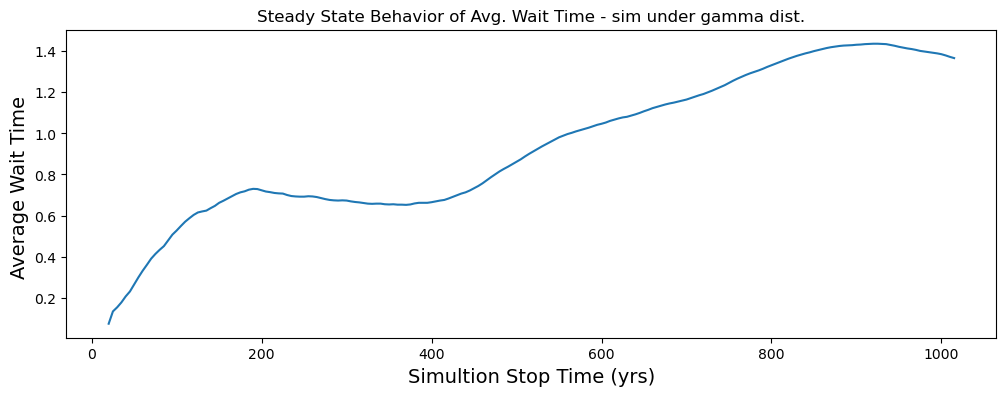

In [40]:
stg1_r.discrete_sim_gamma(0)
stg1_r.get_steady_state(20, 5, 200)

### Strategy 1 (under G/G/2) simulation with ultiple seeds: 

In [10]:
# Generate seeds: 
rand.seed(0)
seeds = [rand.randint(0, 100) for i in range(10)] #<--- CHANGE THE NUMER OF SEEDS HERE
# Create a new G/G/2 queue system where the CV for both patients and donors per year is 1:
stg1_r = queue(data.avg_patients.sum(), data.avg_donors.mean(), mode = "G/G", c=2, cv_a=1, cv_s=1, unit=unit)
stg1_r.verbose = 0
# Get params again: 
stg1_r.get_params()
# Get simulations again: 
result = stg1_r.multi_seed_sim(seed=seeds, sim_mode='gamma', stop_count=80000)

Iterating seeds...: 100%|██████████| 10/10 [01:23<00:00,  8.38s/it]


In [11]:
# Average this result to get what you want:
result

,system_time,queue_time,utilization
49,158.925,157.261,"[0.996443886254466, 0.9947349753148766]"
97,97.888,96.222,"[0.9949494072579298, 0.9926760720489637]"
53,70.277,68.608,"[0.9933512012066072, 0.9907040245518396]"
5,117.248,115.582,"[0.9943229089577312, 0.9919555414575182]"
33,66.358,64.694,"[0.9932050077847304, 0.9910744733311311]"
65,267.116,265.45,"[0.9945477754445488, 0.9927632098146675]"
62,74.082,72.417,"[0.9911165883697928, 0.986938140688776]"
51,212.472,210.799,"[0.9951019357410187, 0.9932625834474569]"
100,105.341,103.677,"[0.9952697758100293, 0.9935749657892412]"
38,491.16,489.482,"[0.9994019756183646, 0.999267465201432]"


### Loop over multiple CVs: 

In [26]:
cv_loops = {}
for cv_arrival in [1, 1.1, 1.2, 1.3, 1.4, 1.5]: 
    for cv_service in [1, 1.1, 1.2, 1.3, 1.4, 1.5]: 
        # Create a new G/G/2 queue system where the CV for both patients and donors per year is 1:
        stg1_r = queue(data.avg_patients.sum(), data.avg_donors.mean(), mode = "G/G", c=2, cv_a=cv_arrival, cv_s=cv_service, unit=unit)
        stg1_r.verbose = 0
        # Get params again: 
        stg1_r.get_params()
        # Get simulations again: 
        result = stg1_r.multi_seed_sim(seed=seeds, sim_mode='gamma', stop_criteria = 'time', stop_count=365*200)
        result_system_time = result.system_time.mean()
        cv_loops[(cv_arrival, cv_service)] = result_system_time

Iterating seeds...:  50%|█████     | 5/10 [00:29<00:28,  5.69s/it]




























































100%|██████████| 73000.0/73000 [00:07<00:00, 9617.08it/s]          
Iterating seeds...:  50%|█████     | 5/10 [00:36<00:36,  7.38s/it]


KeyboardInterrupt: 

In [25]:
cv_loops

{(1, 1): 43.6707,
 (1, 1.1): 43.6707,
 (1, 1.2): 43.6707,
 (1, 1.3): 43.6707,
 (1, 1.4): 43.6707,
 (1, 1.5): 43.6707,
 (1.1, 1): 43.6707,
 (1.1, 1.1): 43.6707,
 (1.1, 1.2): 43.6707,
 (1.1, 1.3): 43.6707,
 (1.1, 1.4): 43.6707,
 (1.1, 1.5): 43.6707,
 (1.2, 1): 43.6707,
 (1.2, 1.1): 43.6707,
 (1.2, 1.2): 43.6707,
 (1.2, 1.3): 43.6707,
 (1.2, 1.4): 43.6707,
 (1.2, 1.5): 43.6707,
 (1.3, 1): 43.6707,
 (1.3, 1.1): 43.6707,
 (1.3, 1.2): 43.6707,
 (1.3, 1.3): 43.6707}

# QA Cases

### Scenario 1: Starbucks (Dedicated Queues with Two Servers) - Two M/M/1 

In [12]:
lbda1 = 95/2  #arrival rate
avg1 = 50    # service rate 

test = queue(lbda1, avg1, c=1, mode='M/M')
test.verbose = 1
test.get_params()


Queue system configuration: M/M, arrival rate: 47.50, service rate: 50.00, total 1 server(s).
Is current queue tandem: False
Utilization rate: 0.950
Length of queue: 18.050, length of system: 19.000
Time in queue: 0.380 years, time in system: 0.400 years
------------------------------------------------------------------------------------------------------------


### Scenario 2: Starbucks (Combined Queues) - M/M/2

In [13]:
lbda2 = 95  #arrival rate
avg2 = 50    # service rate 

test = queue(lbda2, avg2, c=2, mode='M/M')
test.verbose = 1
test.get_params()

Queue system configuration: M/M, arrival rate: 95.00, service rate: 50.00, total 2 server(s).
Is current queue tandem: False
Utilization rate: 0.950
Length of queue: 17.587, length of system: 19.487
Time in queue: 0.185 years, time in system: 0.205 years
------------------------------------------------------------------------------------------------------------


### Scenario 3: Starbucks (Tamdem Queues)

In [14]:
lbda3 = 95  #arrival rate
avg3 = 100  # service rate 

test = queue(lbda3, avg3, c=1, mode='M/M', tandem_queue=True)
test.verbose = 1
test.get_params()

Queue system configuration: M/M, arrival rate: 95.00, service rate: 100.00, total 1 server(s).
Is current queue tandem: True
Utilization rate: 0.950
Length of queue: 18.050, length of system: 19.000
Time in queue: 0.380 years, time in system: 0.400 years
------------------------------------------------------------------------------------------------------------


### Scenario 4: Starbucks (Tamdem Queues, with improvements)

In [15]:
lbda3 = 95  #arrival rate
avg3 = 105  # service rate 

test = queue(lbda3, avg3, c=1, mode='M/M', tandem_queue=True)
test.verbose = 1
test.get_params()

Queue system configuration: M/M, arrival rate: 95.00, service rate: 105.00, total 1 server(s).
Is current queue tandem: True
Utilization rate: 0.905
Length of queue: 8.595, length of system: 9.500
Time in queue: 0.181 years, time in system: 0.200 years
------------------------------------------------------------------------------------------------------------
